In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as tfms
from typing import List

from PIL import Image
import matplotlib.pylab as plt
import numpy as np

%matplotlib inline

/home/sanjay/.conda/envs/pyg/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/sanjay/.conda/envs/pyg/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c105ErrorC2ENS_14SourceLocationESs
  warn(f"Failed to load image Python extension: {e}")


In [2]:
fname = 'Rock-Paper-Scissors/train/scissors/scissors01-000.png'

In [3]:
img = Image.open(fname).convert('RGB')
img_torch = torch.from_numpy(np.array(img)).permute(2,0,1)
img_torch_norm = img_torch.float() / 255.

In [53]:
class CustomTransform(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.t1 = tfms.Resize((256, 256))
        self.t2 = tfms.CenterCrop((224, 224))
        self.t3 = tfms.Normalize(mean=[0.485, 0.456, 0.406], \
                                 std=[0.229, 0.224, 0.225])
        
    def forward(self, x):
        return self.t3(self.t2(self.t1(x)))
    
class CustomTransformList(nn.Module):
    def __init__(self, t):
        super().__init__()
        
        self.t = nn.ModuleList(t)
            
        
    def forward(self, x):
        for transform in self.t:
            x = transform(x)
            
        return x
    
class Wrapper(nn.Module):
    def __init__(self, net, transform):
        super().__init__()
        
        self.net = net
        self.transform = transform
        
    def  forward(self, x):
        x = self.transform(x)
        return self.net(x)

In [94]:
v = CustomTransform()
w = torch.jit.script(v)
a = w(img_torch_norm)

In [95]:
v = CustomTransformList([tfms.Resize((224, 224)), \
                         #tfms.Resize((256, 256))
                         #tfms.CenterCrop((224, 224)), \
                         tfms.Normalize(mean=[0.485, 0.456, 0.406], \
                                        std=[0.229, 0.224, 0.225])])
w = torch.jit.script(v)
b = w(img_torch_norm)

In [93]:
(a-b).abs().sum()

tensor(16641.6426)

In [96]:
net = Wrapper(nn.Conv2d(3,12,kernel_size=3), v)
net_jit = torch.jit.script(net)

In [97]:
torch.onnx.export(net,
                 torch.rand_like(img_torch_norm),
                 'test.onnx')

In [103]:
%run model

In [104]:
a = CustomTransformList(transform)

In [105]:
Model(nn.Conv2d(3,12,(3,3)), inference_transform_list)

TypeError: transform should be of type CustomTransformList

In [2]:
from preprocess import *

In [27]:
def canny(fname): 
    img = cv2.imread(fname) 

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_blur = cv2.GaussianBlur(img_gray, (3,3), 0) 
 
    edges = cv2.Canny(image=img_blur, threshold1=180, threshold2=200) # Canny Edge Detection
    
    return img, edges

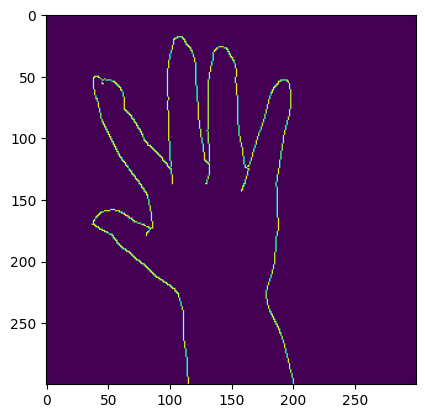

In [44]:
i, e = canny('../Rock-Paper-Scissors/train/paper/paper01-068.png')
plt.imshow(e)

In [28]:
i, e = canny('../Rock-Paper-Scissors/train_aug24/paper/p1.jpg')

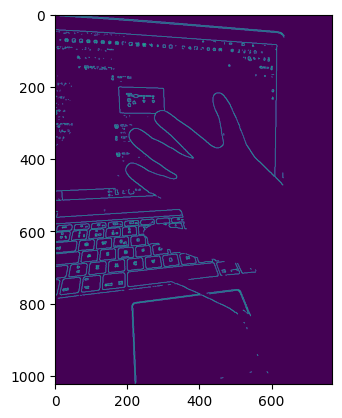

In [29]:
plt.imshow(e)

In [40]:
contours, hierarchy = cv2.findContours(e, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [41]:
np.argmax([len(contours[i]) for i in range(len(contours))])

251

In [39]:
hierarchy

array([[[  1,  -1,  -1,  -1],
        [  2,   0,  -1,  -1],
        [  3,   1,  -1,  -1],
        ...,
        [523, 521,  -1,  -1],
        [524, 522,  -1,  -1],
        [ -1, 523,  -1,  -1]]], dtype=int32)

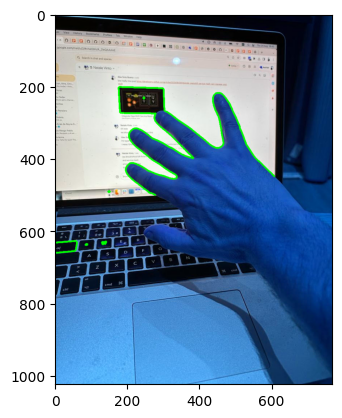

In [42]:
plt.imshow(cv2.drawContours(i, [contours[251]], 0, (0,255,0), 3))

In [91]:
from data import get_ds_dl
ds_train, ds_test, dl_train, dl_test = get_ds_dl(transform, 
                                                    1,
                                                    train_folder,
                                                    test_folder)


In [92]:
ds_train.classes

['paper', 'rock', 'scissors']

In [93]:
ds_test.classes

['paper', 'rock', 'scissors']

#### Test ONNX on files from validation set

In [56]:
import glob
from data import get_ds_dl
from model import get_resnet
from export import create_session, predict

In [90]:
#CHANGE THIS TO TEST MODEL
train_folder = '../Rock-Paper-Scissors/train_aug2425/'
test_folder = '../Rock-Paper-Scissors/train/'

onnx_file = 'test.onnx'

In [77]:
ds_train, ds_test, dl_train, dl_test = get_ds_dl(transform, 
                                                 1,
                                                 train_folder,
                                                 test_folder)
classes = ds_train.classes

In [94]:
train_fnames = glob.glob(f'{train_folder}/*/*')
test_fnames = glob.glob(f'{test_folder}/*/*')

In [95]:
_, transform = get_resnet()
transform = tfms.Compose([transform, 
                          tfms.RandomRotation(45),
                          tfms.RandomHorizontalFlip()])

In [96]:
sess = create_session(onnx_file)

In [105]:
print(len(train_fnames))
print(len(test_fnames))

40
2520


In [108]:
#fname_list = train_fnames
fname_list = test_fnames #PICK WHICH IMAGES YOU WANT TO TEST OVER
plot = False
total = 0
incorrect = []

for idx in range(len(fname_list)):
    fname = fname_list[idx]

    #get predictions and labels
    pred = predict(sess, fname, transform)
    label = fname.split("/")[-2]
    pred_class = classes[pred.argmax()]

    if label==pred_class: #only look at incorrect predictions
        continue
    
    if plot:
        plt.figure()
        plt.imshow(Image.open(fname).convert('RGB')) #plot raw image
        _ = plt.title(f'label = {label} pred = {pred_class} \n pred_logits = {pred}\n classes = {classes}')
    
    total += 1 #a counter to limit how many examples being looked at
    incorrect.append((label, pred_class, pred))
    #if total > 10:
    #    break